<a href="https://colab.research.google.com/github/Sayanabha/Billify/blob/main/Receipt_Radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports for Zephyr-7B

In [ ]:
# Install transformers from source - only needed for versions <= v4.34
%pip install git+https://github.com/huggingface/transformers.git
%pip install accelerate

## Imports for PaddleOCR

In [ ]:
#Only needed for Google Collab, Ignore if running in local machine
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

fatal: destination path 'PaddleOCR' already exists and is not an empty directory.


In [ ]:
!python3 -m pip install paddlepaddle-gpu

In [ ]:
!pip install "paddleocr>=2.0.1"

## OCR using PaddleOCR

In [ ]:
from paddleocr import PaddleOCR,draw_ocr
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en',use_space_char=True,show_log=False,enable_mkldnn=True)

/usr/local/lib/python3.10/dist-packages/paddle/base/framework.py:688: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


In [ ]:
from google.colab.patches import cv2_imshow
import cv2

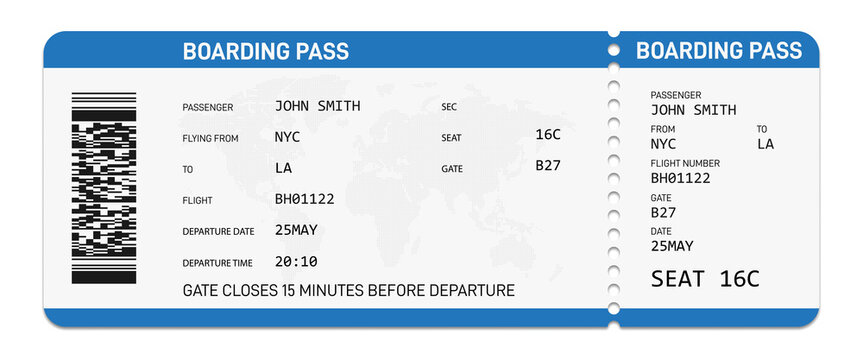

In [ ]:
img_path = '/content/sample1.jpg'

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

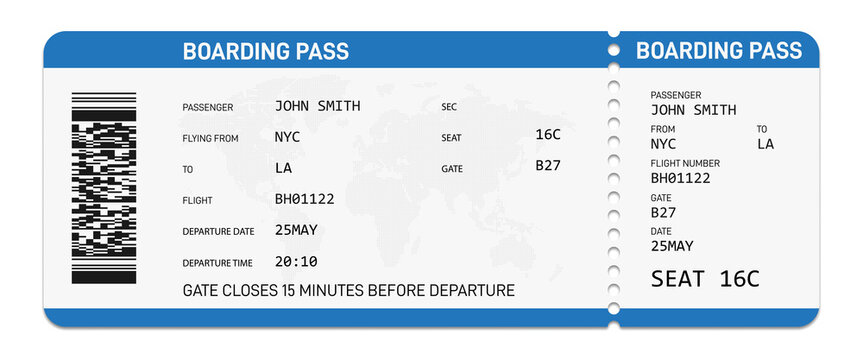

In [ ]:
img_path = '/content/sample1.jpg'

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
result = ocr.ocr(img_path, cls=True)

In [ ]:
ocr_string = ""
# Extract the text from the OCR result and concatenate it to ocr_string
for i in range(len(result[0])):
    ocr_string = ocr_string + result[0][i][1][0] + " "

In [ ]:
ocr_string

'BOARDING PASS BOARDING PASS JOHN SMITH PASSENGER PASSENGER SEC JOHN SMITH NYC 16C FROM TO FLYING FROM SEAT NYC LA LA B27 TO GATE FLIGHT NUMBER BH01122 FLIGHT BH01122 GATE B27 DEPARTURE DATE 25MAY DATE 25MAY DEPARTURE TIME 20:10 SEAT 16C GATE CLOSES 15 MINUTES BEFORE DEPARTURE C '

## OCR Output Parsing using LLM

In [ ]:
import torch
from transformers import pipeline

In [ ]:
pipe = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-alpha", torch_dtype=torch.bfloat16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
ocr_string="BOARDING PASS BOARDING PASS JOHN SMITH PASSENGER PASSENGER SEC JOHN SMITH NYC 16C FROM TO FLYING FROM SEAT NYC LA LA B27 TO GATE FLIGHT NUMBER BH01122 FLIGHT BH01122 GATE B27 DEPARTURE DATE 25MAY DATE 25MAY DEPARTURE TIME 20:10 SEAT 16C GATE CLOSES 15 MINUTES BEFORE DEPARTURE C"

In [ ]:
# Each message can have 1 of 3 roles: "system" (to provide initial instructions), "user", or "assistant". For inference, make sure "user" is the role in the final message.
messages = [
    {
        "role": "system",
        "content": "You are a JSON converter which receives raw boarding pass OCR information as a string and returns a structured JSON output by organising the information in the string.",
    },
    {"role": "user", "content": f"Extract the name of the passenger, name of the airline, Flight number, City of Departure, City of Arrival, Date of Departure from this OCR data: {ocr_string}"},
]
# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|system|>
You are a JSON converter which receives raw boarding pass OCR information as a string and returns a structured JSON output by organising the information in the string.</s>
<|user|>
Extract the name of the passenger, name of the airline, Flight number, City of Departure, City of Arrival, Date of Departure from this OCR data: BOARDING PASS BOARDING PASS JOHN SMITH PASSENGER PASSENGER SEC JOHN SMITH NYC 16C FROM TO FLYING FROM SEAT NYC LA LA B27 TO GATE FLIGHT NUMBER BH01122 FLIGHT BH01122 GATE B27 DEPARTURE DATE 25MAY DATE 25MAY DEPARTURE TIME 20:10 SEAT 16C GATE CLOSES 15 MINUTES BEFORE DEPARTURE C</s>
<|assistant|>



In [ ]:
outputs = pipe(prompt, max_new_tokens=1000, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

In [ ]:
### All in one

In [ ]:
def Image_to_JSON(image_path):
    # Perform OCR on the image and extract the text content
    result = ocr.ocr(image_path, cls=True)

    ocr_string = ""  # Stores the OCR content extracted from the image in a string which can be fed into ChatGPT

    # Extract the text from the OCR result and concatenate it to ocr_string
    for i in range(len(result[0])):
        ocr_string = ocr_string + result[0][i][1][0] + " "

    messages = [
    {
        "role": "system",
        "content": "You are a JSON converter which receives raw boarding pass OCR information as a string and returns a structured JSON output by organising the information in the string.",
    },
    {"role": "user", "content": f"Extract the name of the passenger, name of the airline, Flight number, City of Departure, City of Arrival, Date of Departure from this OCR data: {ocr_string}"},
    ]
    # We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=1000, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
    print(outputs[0]["generated_text"])

In [ ]:
Image_to_JSON('/content/sample1.jpg')

<|system|>
You are a JSON converter which receives raw boarding pass OCR information as a string and returns a structured JSON output by organising the information in the string.</s>
<|user|>
Extract the name of the passenger, name of the airline, Flight number, City of Departure, City of Arrival, Date of Departure from this OCR data: BOARDING PASS BOARDING PASS JOHN SMITH PASSENGER PASSENGER SEC JOHN SMITH NYC 16C FROM TO FLYING FROM SEAT NYC LA LA B27 TO GATE FLIGHT NUMBER BH01122 FLIGHT BH01122 GATE B27 DEPARTURE DATE 25MAY DATE 25MAY DEPARTURE TIME 20:10 SEAT 16C GATE CLOSES 15 MINUTES BEFORE DEPARTURE C </s>
<|assistant|>
```json
{
  "title": "BOARDING PASS BOARDING PASS",
  "passenger": {
    "name": "JOHN SMITH"
  },
  "airline": "PASSENGER",
  "flight": {
    "flightNumber": "FLIGHT BH01122",
    "departureDate": "25MAY",
    "departureTime": "20:10"
  },
  "departure": {
    "city": "NYC",
    "gate": "B27",
    "closes": "15 MINUTES BEFORE DEPARTURE"
  },
  "arrival": {
    "

In [ ]:
import json

def Image_to_JSON(image_path):
    # ... (Existing code remains same)

    # Get the generated text from the LLM
    generated_text = outputs[0]["generated_text"]

    # Attempt to parse the generated text as JSON
    try:
        json_data = json.loads(generated_text)

        # Save the JSON data to a file
        with open('result.json', 'w') as f:
            json.dump(json_data, f, indent=4)

        print("result.json created successfully!")

    except json.JSONDecodeError as e:
        print("Error: Unable to decode JSON from generated text.")
        print(e)